**João Lucas Lage Gonçalves**

**23052002**

# Descrição


# Carregar os dados

In [37]:
%pip install matplotlib
%pip install socceraction


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [38]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
import socceraction.spadl as spadl
from socceraction.data.wyscout import PublicWyscoutLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [39]:
DATA_DIR = 'data'
WYL = PublicWyscoutLoader(root=DATA_DIR)
TRAIN_COMPETITIONS = ['German first division', 'Italian first division', 'French first division', 'Spanish first division', 'English first division']
TEST_COMPETITIONS = ['World Cup', 'European Championship']

competitions = WYL.competitions()

train_competions = competitions[competitions.competition_name.isin(TRAIN_COMPETITIONS)]
test_competions = competitions[competitions.competition_name.isin(TEST_COMPETITIONS)]

# Load all matches of the training competitions
train_games = pd.concat([
    WYL.games(competition_id=competition.competition_id, season_id=competition.season_id)
    for competition in train_competions.itertuples()
])

print(train_games.head())

test_games = pd.concat([
    WYL.games(competition_id=competition.competition_id, season_id=competition.season_id)
    for competition in test_competions.itertuples()
])

test_games.head()


   game_id  competition_id  season_id           game_date  game_day  \
0  2576335             524     181248 2018-05-20 18:45:00        38   
1  2576336             524     181248 2018-05-20 18:45:00        38   
2  2576329             524     181248 2018-05-20 16:00:00        38   
3  2576330             524     181248 2018-05-20 16:00:00        38   
4  2576331             524     181248 2018-05-20 16:00:00        38   

   home_team_id  away_team_id  
0          3162          3161  
1          3315          3158  
2          3173          3172  
3          3165          3219  
4          3163          3166  


,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,1694440,102,9291,2016-07-10 19:00:00,0,9905,4418
1,1694439,102,9291,2016-07-07 19:00:00,0,3148,4418
2,1694438,102,9291,2016-07-06 19:00:00,0,9905,10682
3,1694437,102,9291,2016-07-03 19:00:00,0,4418,7839
4,1694436,102,9291,2016-07-02 19:00:00,0,3148,3757


In [40]:
games_verbose = list(train_games.itertuples())

training_actions = []
for game in tqdm(games_verbose, desc="Converting training games to SPADL ({} games)".format(len(games_verbose)), total=len(games_verbose)):
    events = WYL.events(game.game_id)
    events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                            'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
    actions_game = spadl.wyscout.convert_to_actions(events, game.home_team_id)
    actions_game = spadl.play_left_to_right(actions=actions_game, home_team_id=game.home_team_id)
    actions_game = spadl.add_names(actions_game)
    actions_game['home_team_id'] = game.home_team_id
    training_actions.append(actions_game)

training_df = pd.concat(training_actions).reset_index(drop=True)

Converting training games to SPADL (1826 games): 100%|██████████| 1826/1826 [12:49<00:00,  2.37it/s] 


In [41]:
games_verbose = list(test_games.itertuples())

test_actions = []
for game in tqdm(games_verbose, desc="Converting test games to SPADL ({} games)".format(len(games_verbose)), total=len(games_verbose)):
    events = WYL.events(game.game_id)
    events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                            'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
    actions_game = spadl.wyscout.convert_to_actions(events, game.home_team_id)
    actions_game = spadl.play_left_to_right(actions=actions_game, home_team_id=game.home_team_id)
    actions_game = spadl.add_names(actions_game)
    actions_game['home_team_id'] = game.home_team_id
    test_actions.append(actions_game)

test_df = pd.concat(test_actions).reset_index(drop=True)

Converting test games to SPADL (115 games): 100%|██████████| 115/115 [01:14<00:00,  1.53it/s]


In [42]:
training_df.head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,home_team_id
0,2576335,1,2.417590,3161,3344,51.45,34.00,39.90,28.56,253668302,0,0,1,0,pass,success,foot,3162
1,2576335,1,3.904412,3161,116349,39.90,28.56,38.85,6.12,253668303,0,0,1,1,pass,success,foot,3162
2,2576335,1,6.484211,3161,135903,38.85,6.12,35.70,19.04,253668304,0,0,1,2,pass,success,foot,3162
3,2576335,1,10.043835,3161,138408,35.70,19.04,37.80,58.48,253668306,0,0,1,3,pass,success,foot,3162
4,2576335,1,14.032070,3161,21094,37.80,58.48,31.50,41.48,253668308,0,0,1,4,pass,success,foot,3162


In [43]:
test_df

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,home_team_id
0,1694440,1,4.782709,9905,7926,52.50,34.68,26.25,48.96,90587161,0,0,1,0,pass,success,foot,9905
1,1694440,1,6.973876,9905,8126,26.25,48.96,31.50,61.20,90587162,0,0,1,1,pass,success,foot,9905
2,1694440,1,9.531543,9905,28907,31.50,61.20,35.70,52.36,90587163,0,0,1,2,pass,success,foot,9905
3,1694440,1,10.575710,9905,70403,35.70,52.36,21.00,48.96,90587165,0,0,1,3,pass,success,foot,9905
4,1694440,1,13.624168,9905,8126,21.00,48.96,30.45,6.12,90587167,0,0,1,4,pass,success,foot,9905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143657,2057954,2,2868.496551,14358,103682,76.65,19.04,81.90,20.40,258613771,0,0,1,1211,pass,success,foot,14358
143658,2057954,2,2870.980334,16521,122577,23.10,47.60,24.15,42.84,258614076,0,9,0,1212,tackle,fail,foot,14358
143659,2057954,2,2872.843120,16521,122577,24.15,42.84,24.15,42.84,258614077,0,8,4,1213,foul,yellow_card,foot,14358
143660,2057954,2,2939.438099,14358,257800,85.05,22.44,105.00,30.60,258613773,5,13,1,1214,shot_freekick,success,foot_right,14358


In [44]:
players = pd.read_json(DATA_DIR+'\players.json')
players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,null


In [45]:
teams = pd.read_json(DATA_DIR+'\\teams.json')
teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


# Tratamento de dados

In [46]:
test_games['game_date'] = pd.to_datetime(test_games['game_date'])
train_games['game_date'] = pd.to_datetime(train_games['game_date'])

test_date = test_games['game_date'].min()
train_date = train_games['game_date'].min()

print(f"Train date: {train_date}")
print(f"Test date: {test_date}")

Train date: 2017-08-04 18:45:00
Test date: 2016-06-10 19:00:00


In [47]:
players['player_name'] = players['firstName'] + ' ' + players['lastName']
players['player_country'] = players['passportArea'].apply(lambda x: x['name'] if x is not None else None)
players['birthDate'] = pd.to_datetime(players['birthDate'])
players['train_age'] = (train_date - players['birthDate']).dt.days // 365
players['test_age'] = (test_date - players['birthDate']).dt.days // 365

players['player_name'] = players['player_name'].str.decode('unicode-escape')
players['player_country'] = players['player_country'].str.decode('unicode-escape')
players['shortName'] = players['shortName'].str.decode('unicode-escape')
players = players.rename(columns={'wyId': 'player_id', 'currentTeamId': 'team_id'})

players = players[['player_id', 'player_name', 'shortName', 'player_country', 'train_age', 'test_age', 'team_id']]

players.head()

,player_id,player_name,shortName,player_country,train_age,test_age,team_id
0,32777,Harun Tekin,H. Tekin,Turkey,28,27,4502
1,393228,Malang Sarr,M. Sarr,Senegal,18,17,3775
2,393230,Over Mandanda,O. Mandanda,France,18,17,3772
3,32793,Alfred John Momar N'Diaye,A. N'Diaye,Senegal,27,26,683
4,393247,Ibrahima Konaté,I. Konaté,France,18,17,2975


In [48]:
teams['team_country'] = teams['area'].apply(lambda x: x['name'] if x is not None else None)
teams['name'] = teams['name'].str.decode('unicode-escape')
teams['team_country'] = teams['team_country'].str.decode('unicode-escape')

teams = teams.rename(columns={'wyId': 'team_id', 'name': 'team_name'})

teams = teams[['team_id', 'team_name', 'team_country']]

teams.head()

,team_id,team_name,team_country
0,1613,Newcastle United,England
1,692,Celta de Vigo,Spain
2,691,Espanyol,Spain
3,696,Deportivo Alavés,Spain
4,695,Levante,Spain


# EDA

<Axes: >

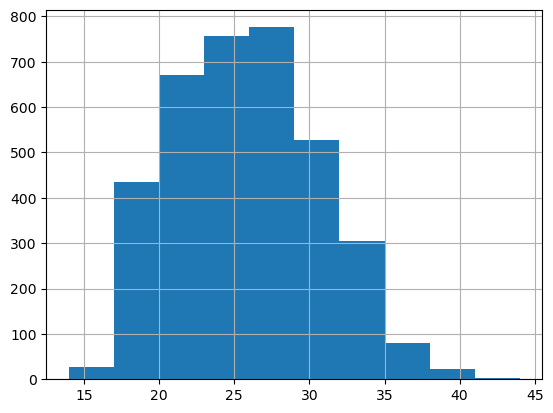

In [49]:
players['train_age'].hist()

# Feature Engeneering

In [50]:
from socceraction.vaep import features as ft
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def createFeatures(actions):
    # actions.loc[actions.result_id.isin([2, 3]), ['result_id']] = 0
    # actions.loc[actions.result_name.isin(['offside', 'owngoal']), ['result_name']] = 'fail'
    xfns = [
        ft.actiontype_onehot,
        ft.bodypart_onehot,
        ft.result_onehot,
        ft.goalscore,
        ft.startlocation,
        ft.endlocation,
        ft.movement,
        ft.space_delta,
        ft.startpolar,
        ft.endpolar,
        ft.team,
        ft.time,
        ft.time_delta
    ]

    features = []
    for game in tqdm(actions.game_id.unique(), desc="Creating features"):
        actions_game = actions[actions.game_id==game].reset_index(drop=True)
        match_states = ft.gamestates(actions=actions_game)
        #match_states = ft.play_left_to_right(match_states,actions_game.home_team_id.unique()[0])
        match_features = pd.concat([fn(match_states) for fn in xfns], axis=1)
        features.append(match_features)

    features = pd.concat(features).reset_index(drop=True)
    #bp_other = [c for c in list(features.columns) if 'bodypart' in c and 'foot' not in c]
    #non_success = [c for c in list(features.columns) if 'result' in c and 'success' not in c]
    #non_action = [c for c in list(features.columns) if 'non_action' in c]
    #keeper = [c for c in list(features.columns) if 'keeper' in c and 'save' not in c]

    #features = features.drop(bp_other + non_success + non_action + keeper, axis=1)
    return features

In [51]:
training_features.head()

,actiontype_pass_a0,actiontype_cross_a0,actiontype_throw_in_a0,actiontype_freekick_crossed_a0,actiontype_freekick_short_a0,actiontype_corner_crossed_a0,actiontype_corner_short_a0,actiontype_take_on_a0,actiontype_foul_a0,actiontype_tackle_a0,...,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,2.417590,2.417590,1.0,2.417590,2.417590,1.0,2.417590,2.417590,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,3.904412,3.904412,1.0,2.417590,2.417590,1.0,2.417590,2.417590,1.486822,1.486822
2,True,False,False,False,False,False,False,False,False,False,...,6.484211,6.484211,1.0,3.904412,3.904412,1.0,2.417590,2.417590,2.579799,4.066621
3,True,False,False,False,False,False,False,False,False,False,...,10.043835,10.043835,1.0,6.484211,6.484211,1.0,3.904412,3.904412,3.559624,6.139423
4,True,False,False,False,False,False,False,False,False,False,...,14.032070,14.032070,1.0,10.043835,10.043835,1.0,6.484211,6.484211,3.988235,7.547859


In [52]:
training_features = createFeatures(training_df)
test_features = createFeatures(test_df)

print(training_features.head())
test_features.head()

Creating features: 100%|██████████| 115/115 [00:19<00:00,  5.96it/s]


   actiontype_pass_a0  actiontype_cross_a0  actiontype_throw_in_a0  \
0                True                False                   False   
1                True                False                   False   
2                True                False                   False   
3                True                False                   False   
4                True                False                   False   

   actiontype_freekick_crossed_a0  actiontype_freekick_short_a0  \
0                           False                         False   
1                           False                         False   
2                           False                         False   
3                           False                         False   
4                           False                         False   

   actiontype_corner_crossed_a0  actiontype_corner_short_a0  \
0                         False                       False   
1                         False                   

,actiontype_pass_a0,actiontype_cross_a0,actiontype_throw_in_a0,actiontype_freekick_crossed_a0,actiontype_freekick_short_a0,actiontype_corner_crossed_a0,actiontype_corner_short_a0,actiontype_take_on_a0,actiontype_foul_a0,actiontype_tackle_a0,...,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,4.782709,4.782709,1.0,4.782709,4.782709,1.0,4.782709,4.782709,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,6.973876,6.973876,1.0,4.782709,4.782709,1.0,4.782709,4.782709,2.191167,2.191167
2,True,False,False,False,False,False,False,False,False,False,...,9.531543,9.531543,1.0,6.973876,6.973876,1.0,4.782709,4.782709,2.557667,4.748834
3,True,False,False,False,False,False,False,False,False,False,...,10.575710,10.575710,1.0,9.531543,9.531543,1.0,6.973876,6.973876,1.044167,3.601834
4,True,False,False,False,False,False,False,False,False,False,...,13.624168,13.624168,1.0,10.575710,10.575710,1.0,9.531543,9.531543,3.048458,4.092625


# Gerando Labels

In [53]:
import socceraction.vaep.labels as lb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def createLabels(actions):
    yfns = [
        lb.scores,
        lb.concedes
    ]

    labels = []
    for game in tqdm(actions.game_id.unique(), desc="Creating labels"):
        actions_game = actions[actions.game_id==game].reset_index(drop=True)
        labels.append(pd.concat([fn(actions=actions_game) for fn in yfns], axis=1))

    labels = pd.concat(labels).reset_index(drop=True)
    return labels

In [54]:
training_labels

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
2320425,False,False
2320426,False,False
2320427,False,False
2320428,False,False


In [55]:
training_labels = createLabels(actions=training_df)
test_labels = createLabels(actions=test_df)

print(training_labels.head())
test_labels.head()

Creating labels:   0%|          | 0/1826 [00:00<?, ?it/s]

Creating labels: 100%|██████████| 115/115 [00:08<00:00, 13.64it/s]

   scores  concedes
0   False     False
1   False     False
2   False     False
3   False     False
4   False     False


,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


# Model Creation   

In [56]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [57]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, accuracy_score
import xgboost as xgb
from sklearn.base import clone

In [76]:
class XGBoostClassifier():
    def __init__(self, n_estimators, max_depth, n_jobs, verbosity):
        self.model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs, verbosity=verbosity)
    
    def fit(self, X, y):    
        self.model.fit(X, y)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)[:, 1].reshape(-1, 1)
    
    def predict(self, X):
        return self.model.predict(X).reshape(-1, 1)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_proba = self.predict_proba(X)
        y_true = y.values
        
        metrics = {}
        metrics = {
            "brier": brier_score_loss(y_true, y_proba),
            "log_loss": log_loss(y_true, y_proba),
            "roc_auc": roc_auc_score(y_true, y_proba),
            "accuracy": accuracy_score(y_true, y_pred)
        }
        return metrics

# Execução

In [70]:
list_n_esn_estimators = [25,50,100]
list_max_depth = [3,5,9]
verbosity=1
n_jobs=-3

In [78]:
metrics_list = []

In [65]:
%pip install graphviz xgboost

  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   ----------------- ---------------------- 20.5/47.1 kB 330.3 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 594.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [79]:
for n_estimators in list_n_esn_estimators:
    for max_depth in list_max_depth:
        for label in test_labels.columns:
            xgbc = XGBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs, verbosity=verbosity)
            xgbc.fit(training_features, training_labels[label])
            metrics = xgbc.evaluate(test_features, test_labels[label])

            xgbc.model.save_model(f"xgbc_{label}_est{n_estimators}_dph{max_depth}.pkl")

            metrics_list.append({
                "model": f"xgbc_{label}_est{n_estimators}_dph{max_depth}",
                "brier": metrics["brier"],
                "log_loss": metrics["log_loss"],
                "roc_auc": metrics["roc_auc"],
                "accuracy": metrics["accuracy"]
            })

            #graph = xgb.to_graphviz(model, num_trees=1)
            #ax = xgb.plot_tree(model, num_trees=1)
            xgbc.model.feature_importances_           

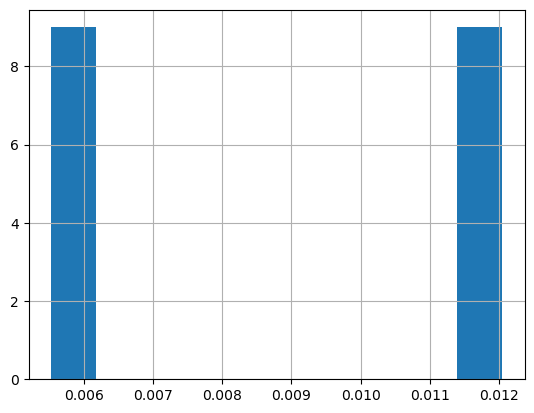

In [83]:
# plot each metric in a bar chart
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df['brier'].hist(label='model')


In [71]:
xgbc = XGBoostClassifier(n_estimators=100, max_depth=9, n_jobs=n_jobs, verbosity=verbosity)
xgbc.fit(training_features, training_labels)
metrics = xgbc.evaluate(test_features, test_labels)
for label in test_labels.columns:
    model = xgbc.models[label]
    model.save_model(f"xgbc_{label}_est{n_estimators}_dph{max_depth}_tm{tree_method}.json")

    metrics_list.append({
        "model": f"xgbc_{label}_est{n_estimators}_dph{max_depth}_tm{tree_method}",
        "brier": metrics[label]["brier"],
        "log_loss": metrics[label]["log_loss"],
        "roc_auc": metrics[label]["roc_auc"],
        "accuracy": metrics[label]["accuracy"]
    })

#graph = xgb.to_graphviz(model, num_trees=1)
#ax = xgb.plot_tree(model, num_trees=1)
model.feature_importances_           

array([0.04854572, 0.00556381, 0.00306948, 0.00334178, 0.00533707,
       0.        , 0.00402229, 0.006553  , 0.0552028 , 0.00793109,
       0.00937639, 0.0048827 , 0.        , 0.        , 0.16726285,
       0.        , 0.        , 0.        , 0.0059744 , 0.00220511,
       0.        , 0.00817859, 0.        , 0.00716   , 0.00427731,
       0.0016822 , 0.00280645, 0.00533769, 0.00100812, 0.00427932,
       0.00435995, 0.00389634, 0.00495908, 0.00466203, 0.00531373,
       0.01281267, 0.0020592 , 0.00526206, 0.        , 0.        ,
       0.        , 0.00345016, 0.        , 0.        , 0.00646649,
       0.00411433, 0.0059762 , 0.00445835, 0.00355602, 0.00297569,
       0.00569579, 0.00228468, 0.00094067, 0.00511522, 0.00479492,
       0.00528639, 0.00525469, 0.00186481, 0.00056256, 0.        ,
       0.00538671, 0.        , 0.        , 0.        , 0.00603529,
       0.        , 0.        , 0.0053309 , 0.00688521, 0.00618928,
       0.00582901, 0.0032554 , 0.        , 0.00587343, 0.00541